# 2025.1112

This notebook analysis 2015 SA pulse with EKF-RNN  
generated by the following program: 
- with Zonal terms, without LOD input:
    - `program_files/2025_1016_learn_derivatives_h34_s0-32_Zonal.py`
    - `program_files/2025_1028_learn_derivatives_h34_s0-32_Zonal_bw.py`
    - `program_files/2025_1030_learn_derivatives_h34_s29_Zonal_d3g.py`
    - `program_files/2025_1031_learn_derivatives_h34_s29_Zonal_d0g.py`
- omnly non-Zonal terms, without LOD input:
    - `program_files/2025_1018_learn_derivatives_h34_s0-32_nonZonal.py`
    - `program_files/2025_1029_learn_derivatives_h34_s0-32_nonZonal_bw.py`
- with LOD input:
    - `program_files/2025_1106_withLOD_h34_s0-32_nonZonal.py`
    - `program_files/2025_1108_withLOD_h34_s0-32_Zonal.py`

for SGEPSS.


Candidate model
- Number of hidden units : `Drec = 34`
- initial $\mathbf{w}_0$ : `seed = best / worst in "00000" - "11111"` (`seed = 29 "11101"` was for IGRF-14)
- Training method : EKF-RNN

`Data Period: MCM-2024 (2004.87〜2024.87)`

- Hindcast experiment (Minami et al., 2020)  
`Train Period: 2004.8739 - 2018.6247 (56 points, 14 yrs )`  
`Valid Period: 2018.8749 - 2023.6254 (20 points, 5 yrs )`  


In [1]:
import platform           # Python 3.9.16
import sys
import re

import numpy      as np   # Numpy 1.23.2
import pandas     as pd   # Pandas 2.0.3
import matplotlib as mpl  # Matplotlib 3.7.1
import seaborn    as sns  # Seaborn 0.12.2

from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, floatmode='fixed', suppress=True)
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams.update({
    'font.size'     : 16,
    'axes.grid'     : True,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
})

print(f"Python Platform: {platform.platform()}")
print(f"    Python {sys.version}")
print(f"     Numpy {np.__version__}")
print(f"    Pandas {pd.__version__}")
print(f"Matplotlib {mpl.__version__}")
print(f"   Seaborn {sns.__version__}")

Python Platform: macOS-15.5-arm64-arm-64bit
    Python 3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:36:04) 
[Clang 18.1.8 ]
     Numpy 1.23.2
    Pandas 2.1.4
Matplotlib 3.7.1
   Seaborn 0.12.2


In [2]:
### Configuration
mcm_load = "../MCM2024/processed/"

dt = 0.25 # Time step
# d_max = 0-4 # Order of the derivative
J = 195 # Number of Gauss coefficients up to degree n=13

Drec = 34 # Dimension of the hidden layer

fS = 2018.8749 # forecast Start time
fE = 2023.6254 # forecast End   time

TS = 2014.1244 + 0.2502 # Jerk at 2015 Start time + leapfrog for SA time
TE = 2017.3739 + 0.2502 # Jerk at 2015 End   time + leapfrog for SA time

idx_TS = 38
idx_TE = 52

# font size
f_large  = 24
f_medium = 18
f_small  = 16
f_tiny   = 12

sig = 2 # Scale factor for the uncertainty plot (\pm s * sigma)

# Define functions


In [3]:
def get_coef_energy(coef_array, time_array, gnames):

    coef_energy_array = np.zeros((len(time_array), len(gnames) + 1), dtype=float) # n==0 is for time

    for i, epoch in enumerate(time_array):
        #- print(epoch)
        coef_energy_array[i, 0] = epoch

        for l, target in enumerate(gnames):
            n = int(target[2:].split(",")[0])

            coef_energy_array[i, l+1] += (n+1) * coef_array[l, i] * coef_array[l, i]
    
    return coef_energy_array.T

In [4]:
def get_energy(coef_array, time_array, gnames):
    energy_array = np.zeros((len(time_array), 14), dtype=float) # n==0 is for time

    for i, epoch in enumerate(time_array):
        #- print(epoch)
        energy_array[i, 0] = epoch

        for l, target in enumerate(gnames):
            n = int(target[2:].split(",")[0])

            energy_array[i, n] += (n+1) * coef_array[l, i] * coef_array[l, i]
    
    return energy_array.T

In [5]:
def remove_zonal_g(g_raw, gname):
    g_nonZonal = g_raw.copy()
    cols_to_drop = []
    for l, col in enumerate(gname):
        # degree n, order m
        match = re.match(r'[gh]\((\d+),(\d+)\)', col)
        if match:
            n = int(match.group(1))
            m = int(match.group(2))
            # print(f"n={n}, m={m}")
            if m == 0:
                cols_to_drop.append(l)
                # print(f"Dropping column: {col}")
    g_nonZonal = np.delete(g_nonZonal, cols_to_drop, axis=0)
    c_nonZonal = [col for i, col in enumerate(gname) if i not in cols_to_drop]
    return g_nonZonal, c_nonZonal

In [6]:
def if_nan_SAgenerate(SA_memo, hindcast, diff):
    CF_time = hindcast['time_memo']
    
    if np.isnan(SA_memo[0, 50]):
        if diff == 0:
            print("  --> NaN found in SA_memo, generating SA from CF series...", end="\n")
            # Generate SA from CF series using finite difference
            CF_memo = hindcast['d0g_memo'] # RNN prediction of Core field
            for i, t in enumerate(CF_time):
                if i in [0, 1, 2]:
                    # print(f"i={i} skipped")
                    continue
                SA_memo[:, i] = (CF_memo[:, i] - 2 * CF_memo[:, i-1] + CF_memo[:, i-2]) / (dt * dt)
            
        elif diff == 1:
            print("  --> NaN found in SA_memo, generating SA from SV series...", end="\n")
            # Generate SA from SV series using finite difference
            SV_memo = hindcast['d1g_memo'] # RNN prediction of SV
            for i, t in enumerate(CF_time):
                if i in [0, 1]:
                    continue
                SA_memo[:, i] = (SV_memo[:, i] - SV_memo[:, i-1]) / dt
        
        else:
            print("  --> NaN found in SA_memo, cannot generate SA from higher derivative orders.", end="\n")
            raise ValueError("SA_memo contains NaN values and cannot be generated.")
        
        return SA_memo
    else:
        return SA_memo

# Load MCM model

In [7]:
d0g_raw = pd.read_csv(f"{mcm_load}/coef_g.csv")  
d1g_raw = pd.read_csv(f"{mcm_load}/coef_d1g.csv")
d2g_raw = pd.read_csv(f"{mcm_load}/coef_d2g.csv")

d0g_raw.set_index('YEAR', inplace=True)
d1g_raw.set_index('YEAR', inplace=True)
d2g_raw.set_index('YEAR', inplace=True)

d0R_raw = np.load(f"{mcm_load}/cvar_R.npy")  
d1R_raw = np.load(f"{mcm_load}/cvar_d1R.npy")
d2R_raw = np.load(f"{mcm_load}/cvar_d2R.npy")

display(d2g_raw.head())
print(d2R_raw[0:5,0:5, 0])
print(d2R_raw[0:5,0:5, 1])
print(d2R_raw[0:5,0:5, 2])
print(d2R_raw[0:5,0:5, 3])
print(d2R_raw[0:5,0:5, -1])

,"g(1,0)","g(1,1)","h(1,1)","g(2,0)","g(2,1)","h(2,1)","g(2,2)","h(2,2)","g(3,0)","g(3,1)",...,"g(18,14)","h(18,14)","g(18,15)","h(18,15)","g(18,16)","h(18,16)","g(18,17)","h(18,17)","g(18,18)","h(18,18)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2004.87390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005.12370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005.37390,-1.30880,2.22560,-0.89280,-0.17440,-0.08800,-0.74240,1.53120,0.15680,-0.06880,0.20320,...,-0.00160,-0.00000,-0.00000,-0.00000,0.00160,0.00000,0.00160,0.00000,0.00160,-0.00160
2005.62410,-0.00000,1.10080,-0.70560,0.47520,-0.55680,-0.27360,1.43360,0.30720,-0.10240,-0.53280,...,0.00160,0.00000,0.00000,0.00000,-0.00160,-0.00000,-0.00160,-0.00160,-0.00160,0.00160
2005.87420,-0.78560,1.80640,-1.30880,0.81440,-0.77440,-0.56000,2.16160,1.32000,0.09280,0.14880,...,-0.00160,-0.00000,-0.00160,-0.00160,0.00000,0.00160,0.00000,0.00160,0.00000,-0.00000


[[2004.87400        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]]
[[2005.12400        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]]
[[2005.37400        nan        nan        nan        nan]
 [       nan   36.30865   -0.34635   -0.11209    1.66008]
 [       nan   -0.34635   20.52914   -0.11124   -0.04573]
 [       nan   -0.11209   -0.11124   25.27605    0.14777]
 [       nan    1.66008   -0.04573    0.14777   18.48007]]
[[2005.62400        nan        nan        nan        nan]
 [       nan   36.29873   -0.34612   -0.11215    1.66007]
 [       na

In [8]:
coef_raw    = [d0g_raw.iloc[:, :J], d1g_raw.iloc[:, :J], d2g_raw.iloc[:, :J]]
Rmatrix_raw = [d0R_raw[:J+1, :J+1, :], d1R_raw[:J+1, :J+1, :], d2R_raw[:J+1, :J+1, :]]

col_raw = coef_raw[0].columns.tolist()
time_raw = coef_raw[0].index.values

print(col_raw)
print(time_raw)
print(d0R_raw[0, 0, :])

['g(1,0)', 'g(1,1)', 'h(1,1)', 'g(2,0)', 'g(2,1)', 'h(2,1)', 'g(2,2)', 'h(2,2)', 'g(3,0)', 'g(3,1)', 'h(3,1)', 'g(3,2)', 'h(3,2)', 'g(3,3)', 'h(3,3)', 'g(4,0)', 'g(4,1)', 'h(4,1)', 'g(4,2)', 'h(4,2)', 'g(4,3)', 'h(4,3)', 'g(4,4)', 'h(4,4)', 'g(5,0)', 'g(5,1)', 'h(5,1)', 'g(5,2)', 'h(5,2)', 'g(5,3)', 'h(5,3)', 'g(5,4)', 'h(5,4)', 'g(5,5)', 'h(5,5)', 'g(6,0)', 'g(6,1)', 'h(6,1)', 'g(6,2)', 'h(6,2)', 'g(6,3)', 'h(6,3)', 'g(6,4)', 'h(6,4)', 'g(6,5)', 'h(6,5)', 'g(6,6)', 'h(6,6)', 'g(7,0)', 'g(7,1)', 'h(7,1)', 'g(7,2)', 'h(7,2)', 'g(7,3)', 'h(7,3)', 'g(7,4)', 'h(7,4)', 'g(7,5)', 'h(7,5)', 'g(7,6)', 'h(7,6)', 'g(7,7)', 'h(7,7)', 'g(8,0)', 'g(8,1)', 'h(8,1)', 'g(8,2)', 'h(8,2)', 'g(8,3)', 'h(8,3)', 'g(8,4)', 'h(8,4)', 'g(8,5)', 'h(8,5)', 'g(8,6)', 'h(8,6)', 'g(8,7)', 'h(8,7)', 'g(8,8)', 'h(8,8)', 'g(9,0)', 'g(9,1)', 'h(9,1)', 'g(9,2)', 'h(9,2)', 'g(9,3)', 'h(9,3)', 'g(9,4)', 'h(9,4)', 'g(9,5)', 'h(9,5)', 'g(9,6)', 'h(9,6)', 'g(9,7)', 'h(9,7)', 'g(9,8)', 'h(9,8)', 'g(9,9)', 'h(9,9)', 'g(10,0)'

# IGRF-submitted result analysis

In [9]:
# plot SA Energy series for s=29
diff = 2
s = 29
b_seed = format(s, '05b')
print(f"Plotting for d={diff}, s={s} ({b_seed})")

yZyZRNN = np.load(f"../trained_models/2025_1017_Zonal/d{diff}g_{Drec}_{b_seed}_geomag_memos.npz", allow_pickle=True)
yLODRNN = np.load(f"../trained_models/2025_1108_LODZonal/d{diff}g_{Drec}_{b_seed}_geomag_memos.npz", allow_pickle=True)

Plotting for d=2, s=29 (11101)


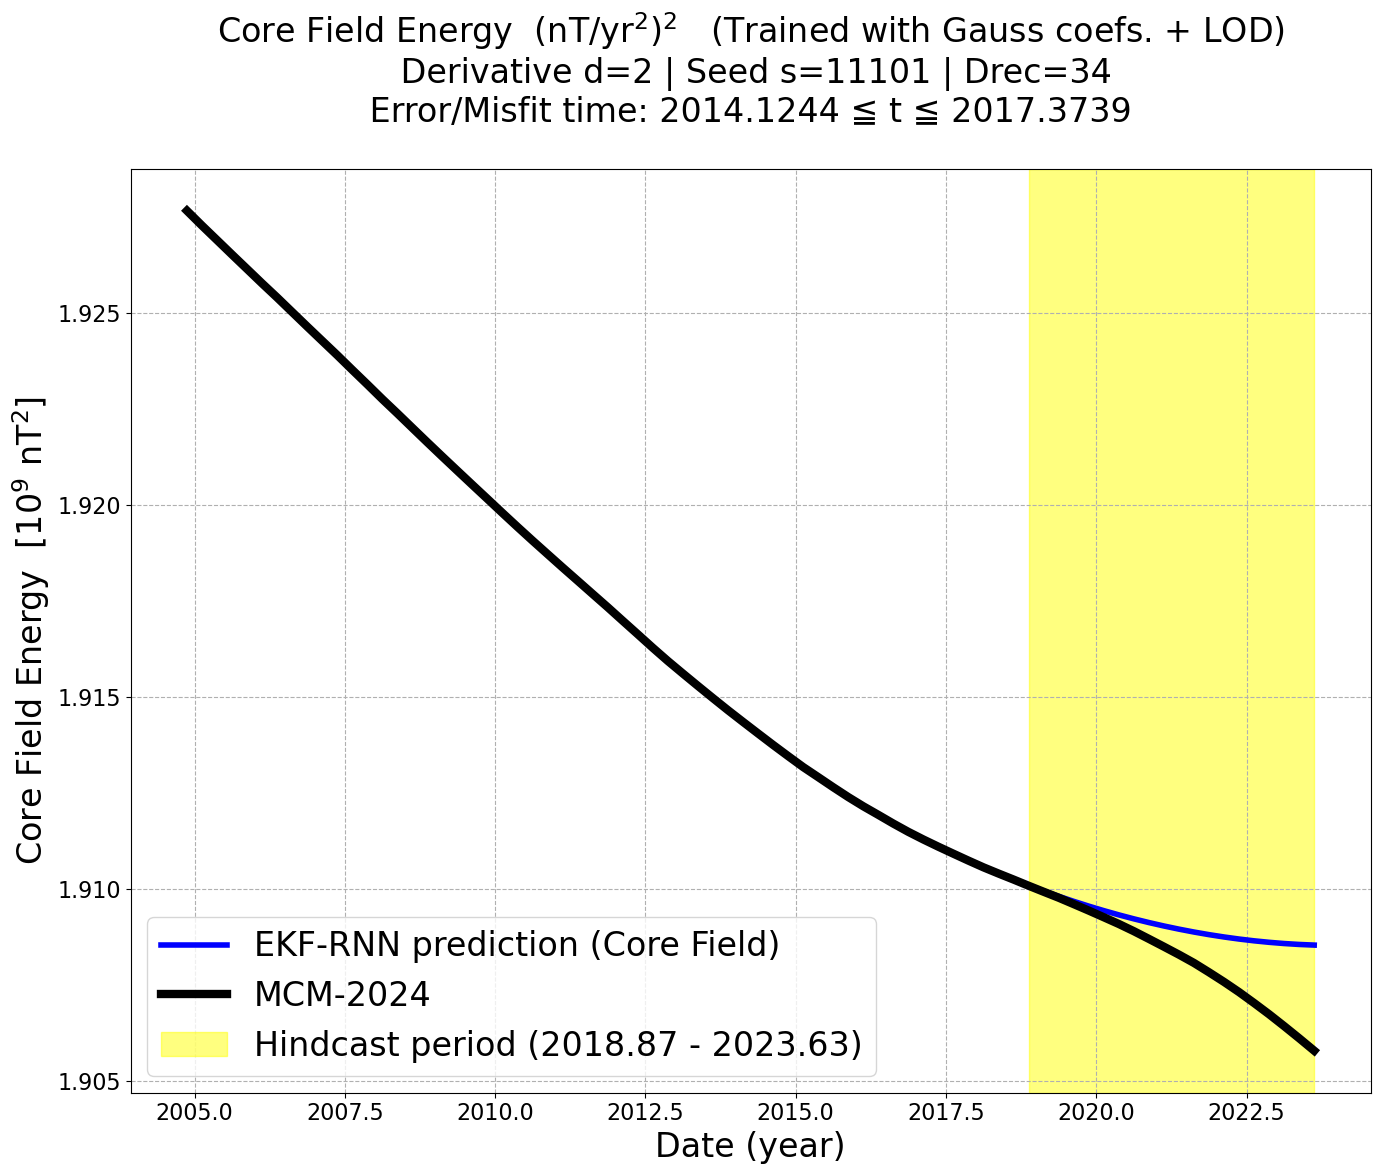

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

## RNN prediction -----------------------------
yZyZ_CF_time = yZyZRNN['time_memo']
yZyZ_CF_memo = yZyZRNN['d0g_memo'] # RNN prediction of CF
yZyZ_CF_Energy_col = get_energy(yZyZ_CF_memo[:J, :], yZyZ_CF_time, yZyZRNN['columns'][:J])
yZyZ_CF_Energy_tot = yZyZ_CF_Energy_col[1:, :].sum(axis=0)

ax.plot(yZyZ_CF_Energy_col[0, :], yZyZ_CF_Energy_tot * 1e-9, 
        color="blue", linewidth=4.0, 
        label="EKF-RNN prediction (Core Field)")

## Reference ----------------------------------
ref_CF = coef_raw[0].loc[yZyZRNN['time_memo'], :].values.T # Reference CF time series
ref_CF_Energy_col = get_energy(ref_CF, yZyZRNN['time_memo'], yZyZRNN['columns'][:J])
ref_CF_Energy_tot = ref_CF_Energy_col[1:, :].sum(axis=0)
ax.plot(ref_CF_Energy_col[0, :], ref_CF_Energy_tot * 1e-9, 
        c='black', linewidth=6.0, 
        label='MCM-2024')

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)

ax.fill_between(yZyZRNN['time_memo'], ymin, ymax, 
            where=(yZyZRNN['time_memo']>=fS) & (yZyZRNN['time_memo']<=fE), 
            color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')


ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel(r"Core Field Energy  $[10^9 \ \mathrm{nT^2}]$", fontsize=f_large)

ax.set_title(r"Core Field Energy  (nT/yr$^2$)$^2$   (Trained with Gauss coefs. + LOD)" + 
        f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
        f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
        fontsize=f_large)

ax.legend(fontsize=f_large, loc='lower left')
plt.show()

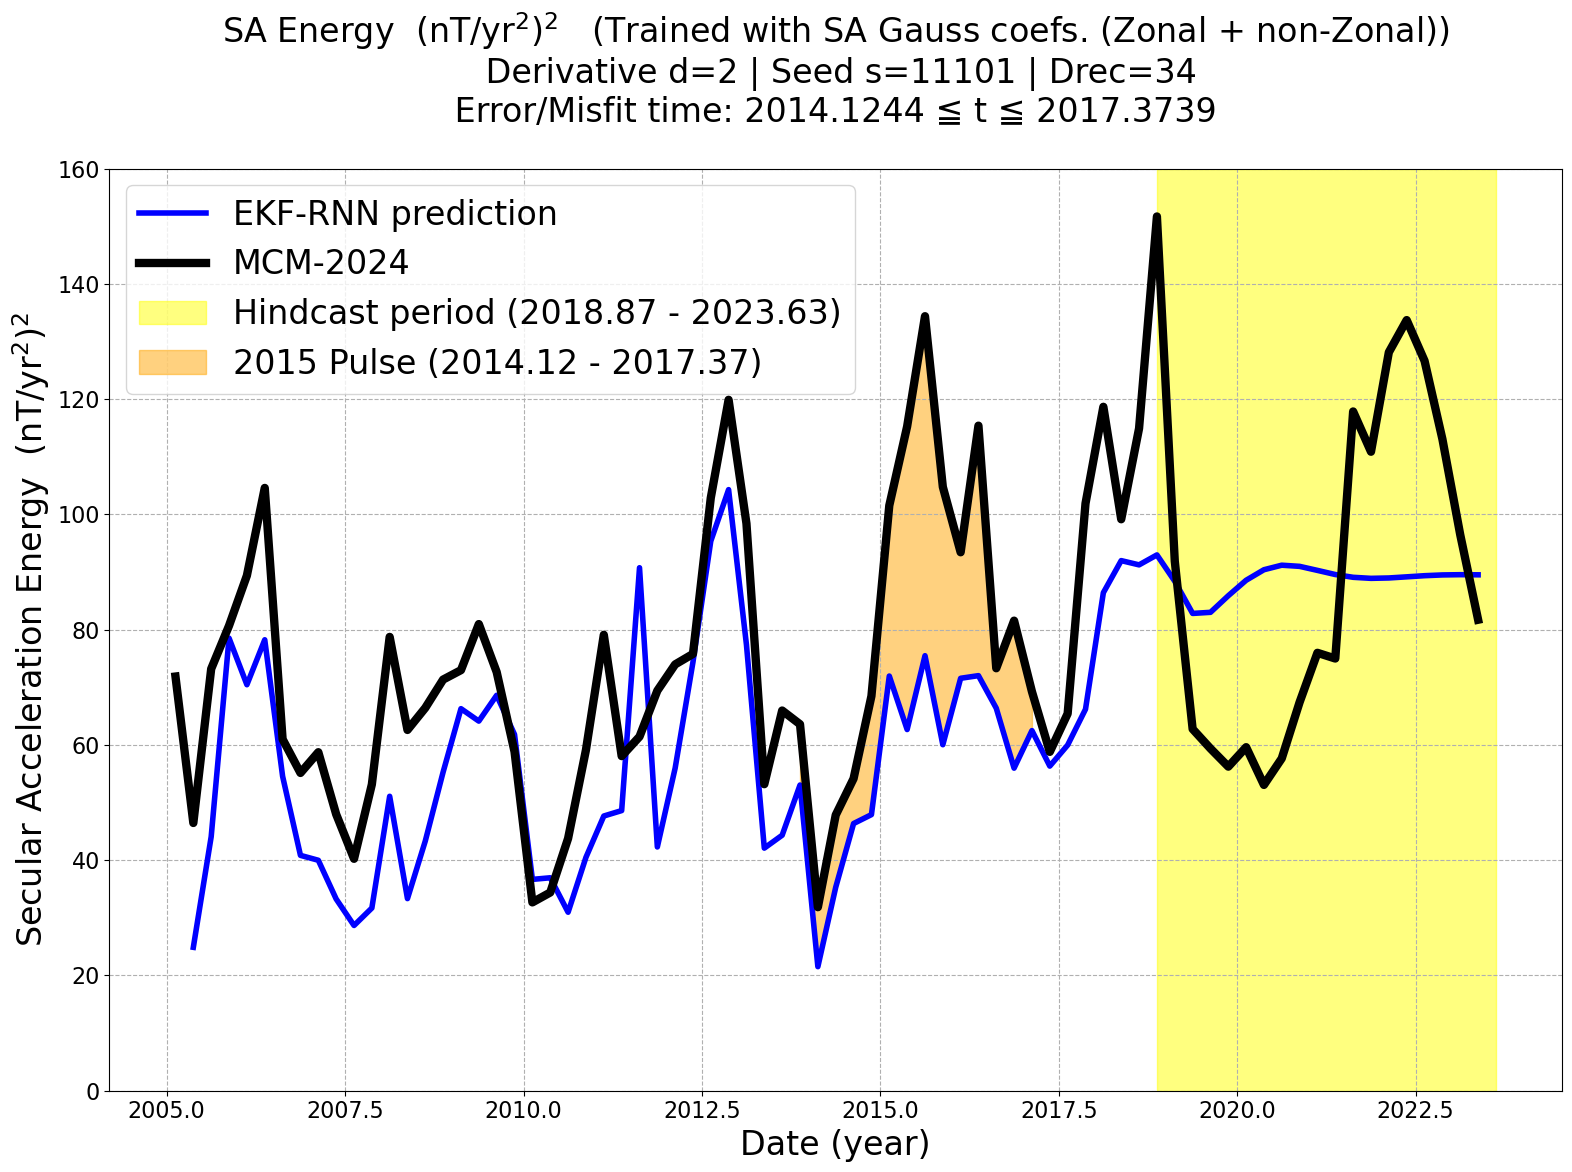

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

## RNN prediction -----------------------------
yZyZ_SA_time = yZyZRNN['time_memo'] - 0.2502  # adjust time for SA leapfrog
yZyZ_SA_memo = yZyZRNN['d2g_memo'] # RNN prediction of SA
yZyZ_SA_Energy_col = get_energy(yZyZ_SA_memo[:J, :], yZyZ_SA_time, yZyZRNN['columns'][:J])
yZyZ_SA_Energy_tot = yZyZ_SA_Energy_col[1:, :].sum(axis=0)

ax.plot(yZyZ_SA_Energy_col[0, :], yZyZ_SA_Energy_tot, 
        color="blue", linewidth=4.0, 
        label="EKF-RNN prediction")

## Reference ----------------------------------
ref_SA = coef_raw[2].loc[yZyZRNN['time_memo'], :].values.T # Reference SA time series
ref_SA_Energy_col = get_energy(ref_SA, yZyZRNN['time_memo'] - 0.2502, yZyZRNN['columns'][:J])
ref_SA_Energy_tot = ref_SA_Energy_col[1:, :].sum(axis=0)
ax.plot(ref_SA_Energy_col[0, :], ref_SA_Energy_tot, 
        c='black', linewidth=6.0, 
        label='MCM-2024')

ymin, ymax = 0, 160
ax.set_ylim(ymin, ymax)

ax.fill_between(yZyZRNN['time_memo'], ymin, ymax, 
            where=(yZyZRNN['time_memo']>=fS) & (yZyZRNN['time_memo']<=fE), 
            color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')

ax.fill_between(yZyZRNN['time_memo']-0.2502, yZyZ_SA_Energy_tot, ref_SA_Energy_tot, 
            where=(yZyZRNN['time_memo']>=TS-0.2502) & (yZyZRNN['time_memo']<=TE-0.2502), 
            color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')

ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel(r"Secular Acceleration Energy  (nT/yr$^2$)$^2$", fontsize=f_large)
ax.set_title(r"SA Energy  (nT/yr$^2$)$^2$   (Trained with SA Gauss coefs. (Zonal + non-Zonal))" + 
        f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
        f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
        fontsize=f_large)

ax.legend(fontsize=f_large, loc='upper left')
plt.tight_layout()
plt.show()

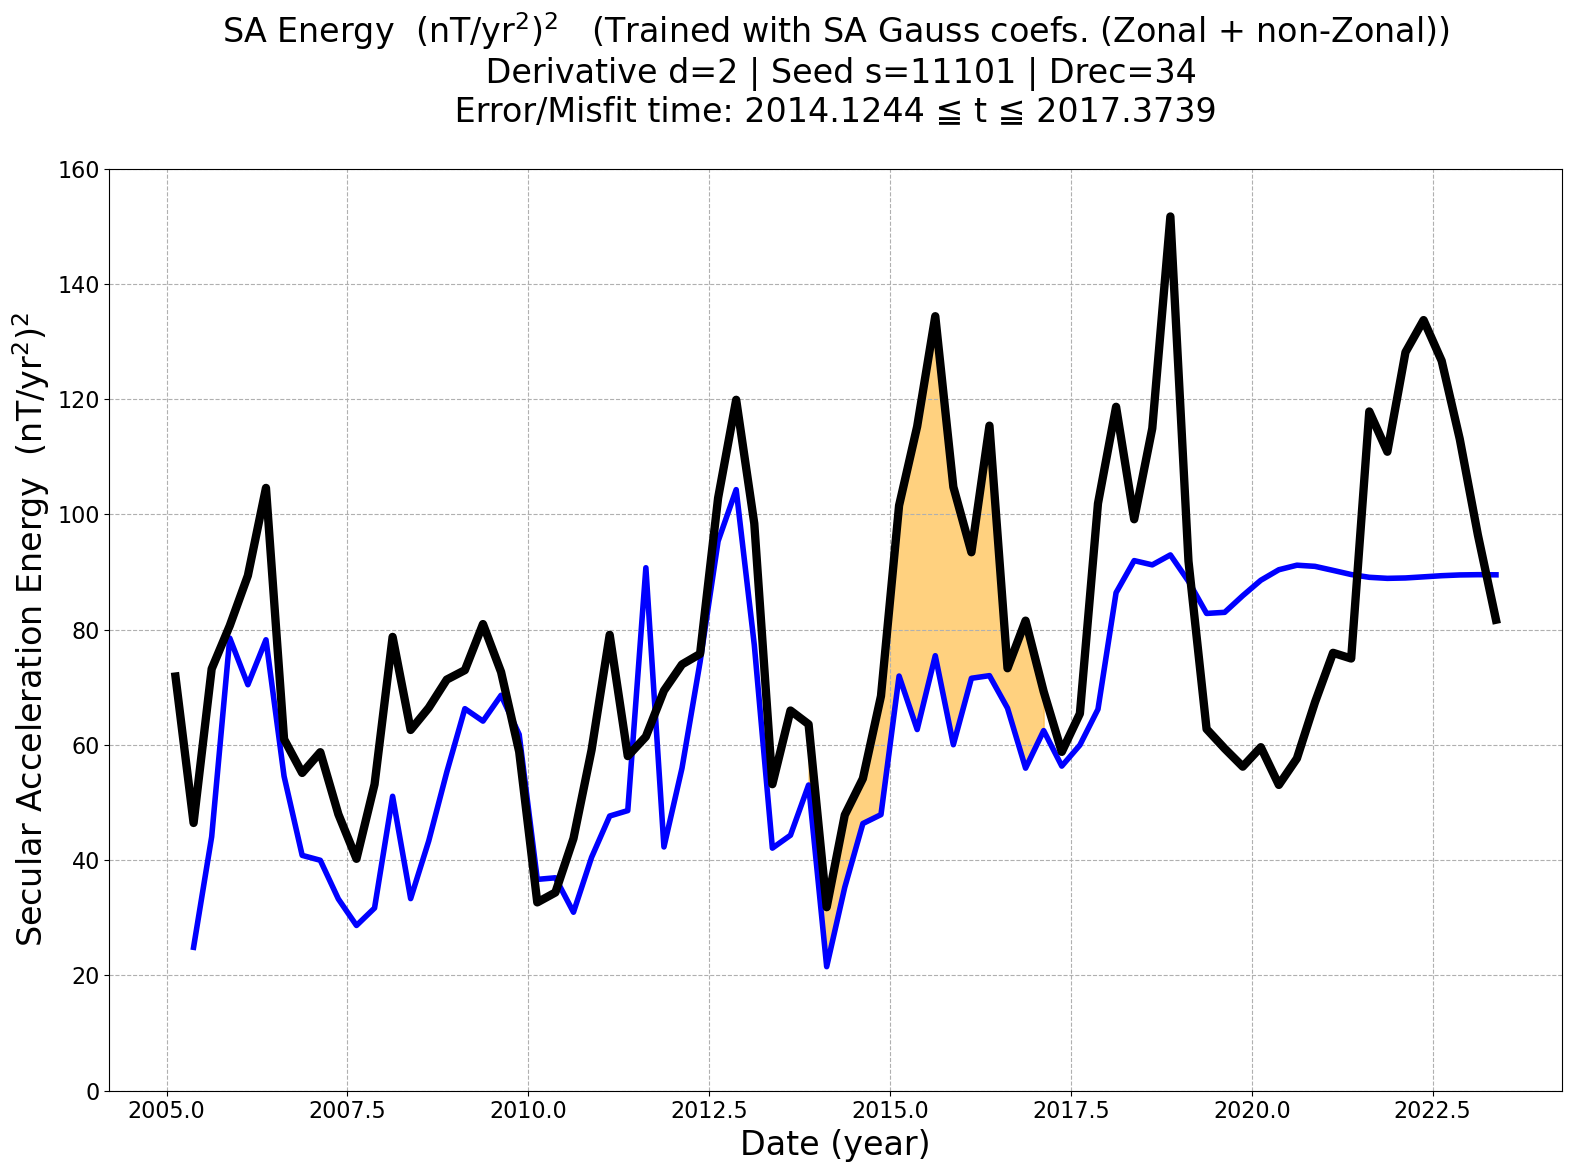

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

## RNN prediction -----------------------------
yZyZ_SA_time = yZyZRNN['time_memo'] - 0.2502  # adjust time for SA leapfrog
yZyZ_SA_memo = yZyZRNN['d2g_memo'] # RNN prediction of SA
yZyZ_SA_Energy_col = get_energy(yZyZ_SA_memo[:J, :], yZyZ_SA_time, yZyZRNN['columns'][:J])
yZyZ_SA_Energy_tot = yZyZ_SA_Energy_col[1:, :].sum(axis=0)

ax.plot(yZyZ_SA_Energy_col[0, :], yZyZ_SA_Energy_tot, 
        color="blue", linewidth=4.0, 
        label="EKF-RNN prediction")

## Reference ----------------------------------
ref_SA = coef_raw[2].loc[yZyZRNN['time_memo'], :].values.T # Reference SA time series
ref_SA_Energy_col = get_energy(ref_SA, yZyZRNN['time_memo'] - 0.2502, yZyZRNN['columns'][:J])
ref_SA_Energy_tot = ref_SA_Energy_col[1:, :].sum(axis=0)
ax.plot(ref_SA_Energy_col[0, :], ref_SA_Energy_tot, 
        c='black', linewidth=6.0, 
        label='MCM-2024')

ymin, ymax = 0, 160
ax.set_ylim(ymin, ymax)

# ax.fill_between(yZyZRNN['time_memo'], ymin, ymax, 
#             where=(yZyZRNN['time_memo']>=fS) & (yZyZRNN['time_memo']<=fE), 
#             color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')

ax.fill_between(yZyZRNN['time_memo']-0.2502, yZyZ_SA_Energy_tot, ref_SA_Energy_tot, 
            where=(yZyZRNN['time_memo']>=TS-0.2502) & (yZyZRNN['time_memo']<=TE-0.2502), 
            color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')

ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel(r"Secular Acceleration Energy  (nT/yr$^2$)$^2$", fontsize=f_large)
ax.set_title(r"SA Energy  (nT/yr$^2$)$^2$   (Trained with SA Gauss coefs. (Zonal + non-Zonal))" + 
        f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
        f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
        fontsize=f_large)

# ax.legend(fontsize=f_large, loc='upper left')
plt.tight_layout()
plt.show()

## 2015 Pulse analysis

### Whose fault?

In [13]:
Elmt_array = get_coef_energy(yZyZ_SA_memo - ref_SA, yZyZRNN['time_memo']-0.2502, yZyZRNN['columns'][:J])

print("Elmt:", Elmt_array[1:, :].sum(axis=0))
print("misfit:", get_energy(yZyZ_SA_memo - ref_SA, yZyZRNN['time_memo']-0.2502, yZyZRNN['columns'][:J])[1:, :].sum(axis=0))

# Elm_array = np.trapz(Elmt_array[1:, 38:52], Elmt_array[0, 38:52], axis=1)
Elm_array = Elmt_array[1:, idx_TS:idx_TE].sum(axis=1)
print(Elm_array)

Elmt: [      nan       nan       nan   6.17856   8.94682   1.78817   5.20597
   8.88668   9.64650  12.38229   9.06032  11.36647   6.96193   7.09122
  10.13365  13.76281   7.74327   6.21812   4.85670   5.32101   5.43974
  14.83883  10.00673  14.43448   6.13547   5.77799  10.64703   2.38240
  16.01134   9.21123  10.00313   0.46927   2.35045   1.97081   5.97775
  10.77786   8.98757   1.14393   3.44360   2.46171   0.95444   5.53583
   6.35785  23.52210  24.82226  12.93648   3.54385  16.59466   1.08327
   4.85068   0.27871   0.40748   1.18432   8.31246   6.73184   1.04471
  13.50414  34.80400  42.48464  64.82111  75.08797 105.12151 137.40788
 174.60208 200.59636 187.60576 215.48581 256.19195 300.34841 271.66559
 337.40250 338.00060 320.18753 285.28181 246.19549 259.57281]
misfit: [      nan       nan       nan   6.17856   8.94682   1.78817   5.20597
   8.88668   9.64650  12.38229   9.06032  11.36647   6.96193   7.09122
  10.13365  13.76281   7.74327   6.21812   4.85670   5.32101   5.43974
 

In [14]:
top_indices = np.argsort(Elm_array)[::-1]
for i in top_indices:
    print(f"{i:>3} | {yZyZRNN['columns'][i]:<9} | {Elm_array[i]:>10.3f}")

  1 | g(1,1)    |     12.304
  3 | g(2,0)    |      8.628
  0 | g(1,0)    |      6.633
  4 | g(2,1)    |      5.399
 17 | h(4,1)    |      4.880
  6 | g(2,2)    |      4.487
 14 | h(3,3)    |      4.267
 11 | g(3,2)    |      3.837
 37 | h(6,1)    |      3.341
  5 | h(2,1)    |      3.319
 18 | g(4,2)    |      3.114
  2 | h(1,1)    |      2.914
  9 | g(3,1)    |      2.822
  7 | h(2,2)    |      2.655
 16 | g(4,1)    |      2.239
 10 | h(3,1)    |      2.206
 33 | g(5,5)    |      2.035
 26 | h(5,1)    |      1.819
  8 | g(3,0)    |      1.760
 34 | h(5,5)    |      1.686
 12 | h(3,2)    |      1.416
 46 | g(6,6)    |      1.304
 20 | g(4,3)    |      1.192
 43 | h(6,4)    |      1.180
 39 | h(6,2)    |      1.139
 45 | h(6,5)    |      1.121
 36 | g(6,1)    |      1.103
 47 | h(6,6)    |      1.004
 23 | h(4,4)    |      1.001
 25 | g(5,1)    |      0.925
 13 | g(3,3)    |      0.912
 22 | g(4,4)    |      0.891
 21 | h(4,3)    |      0.870
 27 | g(5,2)    |      0.678
 35 | g(6,0)  

[    nan     nan     nan 1.12085 2.00375 0.08474 0.13349 0.34097 0.05184
 1.88589 0.02162 0.36217 0.35807 0.63844 0.23780 0.29912 0.69181 1.15631
 0.01820 0.00482 0.11156 0.13315 0.03924 0.01005 2.11846 0.70166 1.72548
 0.29976 0.10179 0.31586 0.44359 0.01634 0.12229 0.07439 0.02847 1.52550
 0.07652 0.23891 0.13506 0.14216 0.04178 1.37183 0.19809 1.96220 2.72270
 3.00525 0.32826 2.22997 0.15106 0.00462 0.00654 0.00444 0.04651 0.58852
 0.18675 0.00540 0.58163]
[    nan     nan     nan 1.42703 2.55879 0.22265 0.27747 1.20612 0.11298
 4.41255 0.55806 0.67936 0.73511 1.65104 3.01535 1.33250 1.51868 1.22037
 1.37851 1.94993 2.34950 0.78334 0.05231 0.03667 2.11907 0.76624 2.42585
 0.40673 0.14630 0.79751 0.58484 0.02924 0.32433 0.07441 0.04102 2.15401
 0.39211 0.64935 0.96601 0.19661 0.09455 1.71777 1.58631 3.11114 2.72433
 3.54698 0.33145 5.34131 0.24544 1.05674 0.00712 0.00618 0.19153 1.27941
 0.46520 0.14843 2.87065]
[    nan     nan     nan 1.42741 3.37418 0.23716 1.10810 3.69820 0.16128

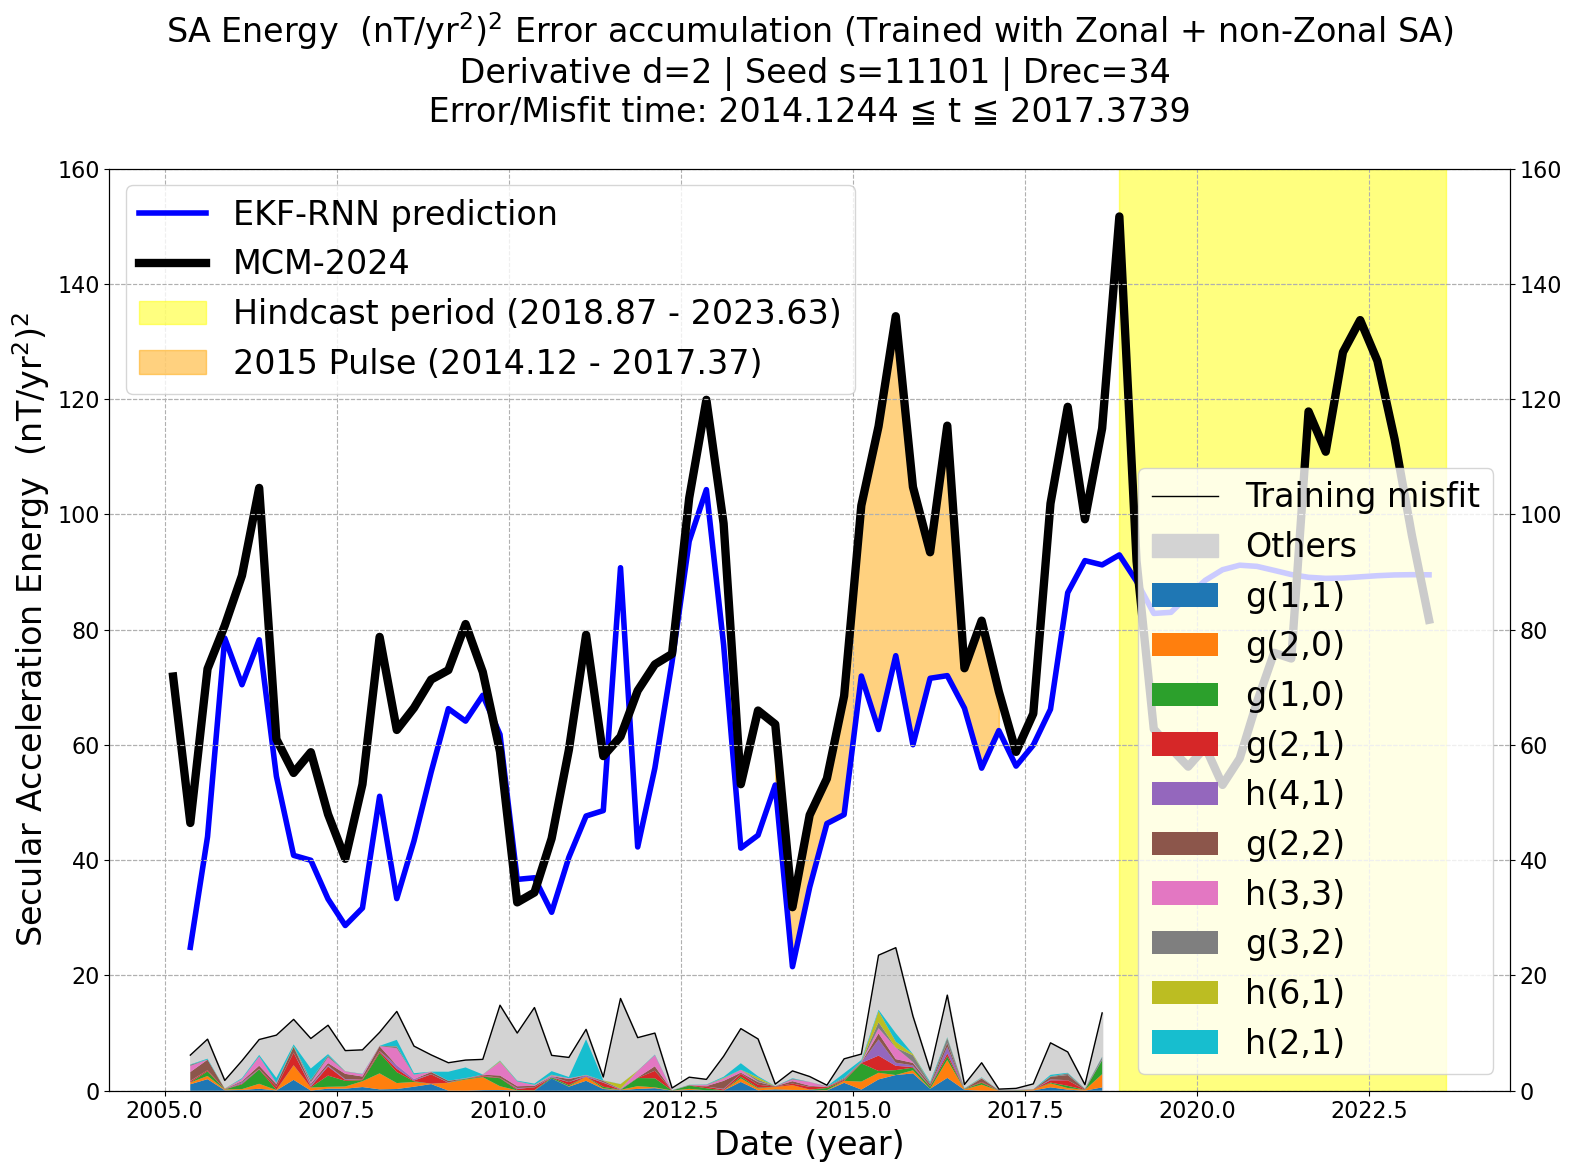

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

## RNN prediction -----------------------------
ax.plot(yZyZ_SA_Energy_col[0, :], yZyZ_SA_Energy_tot, 
        color="blue", linewidth=4.0, 
        label="EKF-RNN prediction")

## Reference ----------------------------------
ax.plot(ref_SA_Energy_col[0, :], ref_SA_Energy_tot, 
        c='black', linewidth=6.0, 
        label='MCM-2024')

ymin, ymax = 0, 160
ax.set_ylim(ymin, ymax)

ax.fill_between(yZyZRNN['time_memo'], ymin, ymax, 
            where=(yZyZRNN['time_memo']>=fS) & (yZyZRNN['time_memo']<=fE), 
            color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')

ax.fill_between(yZyZRNN['time_memo']-0.2502, yZyZ_SA_Energy_tot, ref_SA_Energy_tot, 
            where=(yZyZRNN['time_memo']>=TS-0.2502) & (yZyZRNN['time_memo']<=TE-0.2502), 
            color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')

ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel(r"Secular Acceleration Energy  (nT/yr$^2$)$^2$", fontsize=f_large)
ax.set_title(r"SA Energy  (nT/yr$^2$)$^2$ Error accumulation (Trained with Zonal + non-Zonal SA)" + 
        f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
        f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
        fontsize=f_large)

bx = ax.twinx()
bx.set_ylim(ymin, ymax)

err_SA_Energy_col = get_energy(yZyZ_SA_memo - ref_SA, yZyZRNN['time_memo'] - 0.2502, yZyZRNN['columns'][:J])
err_SA_Energy_tot = err_SA_Energy_col[1:, :].sum(axis=0)
bx.plot(err_SA_Energy_col[0, :57], err_SA_Energy_tot[:57], 
        c='black', linewidth=1.0, label='Training misfit')

bx.fill_between(err_SA_Energy_col[0, :57], 0, err_SA_Energy_tot[:57], 
                color='lightgray', alpha=1.0, label=f'Others')

pile_base = np.zeros(57)
for k, l in enumerate(top_indices[:10]):
        bx.fill_between(Elmt_array[0, :57], pile_base, pile_base + Elmt_array[l+1, :57], 
                        alpha=1.0, label=f"{ yZyZRNN['columns'][l]}")
        pile_base += Elmt_array[l+1, :57]
        print(pile_base)

ax.legend(fontsize=f_large, loc='upper left')
bx.legend(fontsize=f_large, loc='lower right')
plt.tight_layout()
plt.show()

## Br SA map

In [16]:
for idx_t in range(idx_TS, idx_TE):
    time = yZyZRNN['time_memo'][idx_t] - 0.2502
    print(f"idx_t={idx_t:2d}, time = {time:.2f}")

    d2g = yZyZRNN['d2g_memo'][:, idx_t]
    d2R = yZyZRNN['d2g_memo'][:, idx_t] * 0
    columns = yZyZRNN['columns'][:J]

    gSA_df = pd.DataFrame(d2g, index=columns)
    dSA_df = pd.DataFrame(np.sqrt(d2R), index=columns)

    ### generate submit file.mod
    w_lines = [
        "# FOR PLOT\n", 
        "# SA field snapshot\n", 
        "# n m gnm hnm uncertainty_gnm uncertainty_hnm\n"
    ]
    print("".join(w_lines))

    for n in range(1, 14):
        for m in range(0, n+1):
            w_line = f"{n:2d} {m:2d} "

            if m == 0: # g(n,0) only
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {0.0:10.2f} {uncertainty_gnm:5.2f} {0.0:5.2f}"
            else: # g(n,m) and h(n,m)
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                hnm = gSA_df.loc[f"h({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_hnm = dSA_df.loc[f"h({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {hnm:10.2f} {uncertainty_gnm:5.2f} {uncertainty_hnm:5.2f}"

            print(w_line)
            w_lines.append(w_line + "\n")

    f = open(f"./SA_cofs/SA_RNN_{time:.2f}.cof", "w", encoding="ascii")
    f.writelines(w_lines)
    f.close()


idx_t=38, time = 2014.12
# FOR PLOT
# SA field snapshot
# n m gnm hnm uncertainty_gnm uncertainty_hnm

 1  0      -0.29       0.00 -0.00  0.00
 1  1      -0.58       0.47 -0.00  0.00
 2  0      -0.16       0.00 -0.00  0.00
 2  1      -0.75      -0.40 -0.00 -0.00
 2  2      -0.41      -0.65 -0.00 -0.00
 3  0       0.05       0.00  0.00  0.00
 3  1       0.17      -0.46  0.00 -0.00
 3  2       0.63       0.39  0.00  0.00
 3  3      -0.23      -0.20 -0.00 -0.00
 4  0      -0.17       0.00 -0.00  0.00
 4  1      -0.63      -0.32 -0.00 -0.00
 4  2       0.27       0.26  0.00  0.00
 4  3       0.19       0.00  0.00  0.00
 4  4      -0.36       0.15 -0.00  0.00
 5  0      -0.21       0.00 -0.00  0.00
 5  1       0.05      -0.34  0.00 -0.00
 5  2       0.17       0.29  0.00  0.00
 5  3      -0.08      -0.12 -0.00 -0.00
 5  4       0.32       0.21  0.00  0.00
 5  5       0.56      -0.16  0.00 -0.00
 6  0      -0.02       0.00 -0.00  0.00
 6  1      -0.14      -0.01 -0.00 -0.00
 6  2       0.22 

In [17]:
for idx_t in range(idx_TS, idx_TE):
    time = yZyZRNN['time_memo'][idx_t] - 0.2502
    print(f"idx_t={idx_t:2d}, time = {time:.2f}")

    d2g = ref_SA[:, idx_t]
    d2R = yZyZRNN['d2g_memo'][:, idx_t] * 0
    columns = yZyZRNN['columns'][:J]

    gSA_df = pd.DataFrame(d2g, index=columns)
    dSA_df = pd.DataFrame(np.sqrt(d2R), index=columns)

    ### generate submit file.mod
    w_lines = [
        "# FOR PLOT\n", 
        "# SA field snapshot\n", 
        "# n m gnm hnm uncertainty_gnm uncertainty_hnm\n"
    ]
    print("".join(w_lines))

    for n in range(1, 14):
        for m in range(0, n+1):
            w_line = f"{n:2d} {m:2d} "

            if m == 0: # g(n,0) only
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {0.0:10.2f} {uncertainty_gnm:5.2f} {0.0:5.2f}"
            else: # g(n,m) and h(n,m)
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                hnm = gSA_df.loc[f"h({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_hnm = dSA_df.loc[f"h({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {hnm:10.2f} {uncertainty_gnm:5.2f} {uncertainty_hnm:5.2f}"

            print(w_line)
            w_lines.append(w_line + "\n")

    f = open(f"./SA_cofs/SA_MCM_{time:.2f}.cof", "w", encoding="ascii")
    f.writelines(w_lines)
    f.close()


idx_t=38, time = 2014.12
# FOR PLOT
# SA field snapshot
# n m gnm hnm uncertainty_gnm uncertainty_hnm

 1  0      -0.26       0.00 -0.00  0.00
 1  1      -0.84       0.87 -0.00  0.00
 2  0       0.37       0.00 -0.00  0.00
 2  1      -1.05      -0.57 -0.00 -0.00
 2  2      -0.04      -0.91 -0.00 -0.00
 3  0       0.05       0.00  0.00  0.00
 3  1       0.19      -0.52  0.00 -0.00
 3  2       0.81       0.24  0.00  0.00
 3  3      -0.23      -0.47 -0.00 -0.00
 4  0      -0.14       0.00 -0.00  0.00
 4  1      -0.72      -0.33 -0.00 -0.00
 4  2       0.19       0.31  0.00  0.00
 4  3       0.28       0.01  0.00  0.00
 4  4      -0.33       0.30 -0.00  0.00
 5  0      -0.28       0.00 -0.00  0.00
 5  1       0.09      -0.44  0.00 -0.00
 5  2       0.18       0.33  0.00  0.00
 5  3      -0.08      -0.04 -0.00 -0.00
 5  4       0.36       0.33  0.00  0.00
 5  5       0.61      -0.15  0.00 -0.00
 6  0       0.01       0.00 -0.00  0.00
 6  1      -0.16       0.01 -0.00 -0.00
 6  2       0.24 

In [18]:
for idx_t in range(idx_TS, idx_TE):
    time = yZyZRNN['time_memo'][idx_t] - 0.2502
    print(f"idx_t={idx_t:2d}, time = {time:.2f}")

    d2g = yZyZRNN['d2g_memo'][:, idx_t] - ref_SA[:, idx_t]
    d2R = yZyZRNN['d2g_memo'][:, idx_t] * 0
    columns = yZyZRNN['columns'][:J]

    gSA_df = pd.DataFrame(d2g, index=columns)
    dSA_df = pd.DataFrame(np.sqrt(d2R), index=columns)

    ### generate submit file.mod
    w_lines = [
        "# FOR PLOT\n", 
        "# SA field snapshot\n", 
        "# n m gnm hnm uncertainty_gnm uncertainty_hnm\n"
    ]
    print("".join(w_lines))

    for n in range(1, 14):
        for m in range(0, n+1):
            w_line = f"{n:2d} {m:2d} "

            if m == 0: # g(n,0) only
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {0.0:10.2f} {uncertainty_gnm:5.2f} {0.0:5.2f}"
            else: # g(n,m) and h(n,m)
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                hnm = gSA_df.loc[f"h({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_hnm = dSA_df.loc[f"h({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {hnm:10.2f} {uncertainty_gnm:5.2f} {uncertainty_hnm:5.2f}"

            print(w_line)
            w_lines.append(w_line + "\n")

    f = open(f"./SA_gap_cofs/SA_RNN-MCM_{time:.2f}.cof", "w", encoding="ascii")
    f.writelines(w_lines)
    f.close()


idx_t=38, time = 2014.12
# FOR PLOT
# SA field snapshot
# n m gnm hnm uncertainty_gnm uncertainty_hnm

 1  0      -0.03       0.00 -0.00  0.00
 1  1       0.26      -0.40 -0.00  0.00
 2  0      -0.53       0.00 -0.00  0.00
 2  1       0.30       0.17 -0.00 -0.00
 2  2      -0.37       0.26 -0.00 -0.00
 3  0      -0.01       0.00  0.00  0.00
 3  1      -0.03       0.06  0.00 -0.00
 3  2      -0.18       0.15  0.00  0.00
 3  3      -0.00       0.27 -0.00 -0.00
 4  0      -0.03       0.00 -0.00  0.00
 4  1       0.09       0.01 -0.00 -0.00
 4  2       0.09      -0.05  0.00  0.00
 4  3      -0.09      -0.01  0.00  0.00
 4  4      -0.03      -0.15 -0.00  0.00
 5  0       0.07       0.00 -0.00  0.00
 5  1      -0.04       0.10  0.00 -0.00
 5  2      -0.01      -0.04  0.00  0.00
 5  3       0.00      -0.07 -0.00 -0.00
 5  4      -0.04      -0.12  0.00  0.00
 5  5      -0.05      -0.01  0.00 -0.00
 6  0      -0.03       0.00 -0.00  0.00
 6  1       0.02      -0.02 -0.00 -0.00
 6  2      -0.02 

In [19]:
for idx_t in range(idx_TS, idx_TE):
    time = yLODRNN['time_memo'][idx_t] - 0.2502
    print(f"idx_t={idx_t:2d}, time = {time:.2f}")

    d2g = yLODRNN['d2g_memo'][:J, idx_t]
    d2R = yLODRNN['d2g_memo'][:J, idx_t] * 0
    columns = yLODRNN['columns'][:J]

    gSA_df = pd.DataFrame(d2g, index=columns)
    dSA_df = pd.DataFrame(np.sqrt(d2R), index=columns)

    ### generate submit file.mod
    w_lines = [
        "# FOR PLOT\n", 
        "# SA field snapshot\n", 
        "# n m gnm hnm uncertainty_gnm uncertainty_hnm\n"
    ]
    print("".join(w_lines))

    for n in range(1, 14):
        for m in range(0, n+1):
            w_line = f"{n:2d} {m:2d} "

            if m == 0: # g(n,0) only
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {0.0:10.2f} {uncertainty_gnm:5.2f} {0.0:5.2f}"
            else: # g(n,m) and h(n,m)
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                hnm = gSA_df.loc[f"h({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_hnm = dSA_df.loc[f"h({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {hnm:10.2f} {uncertainty_gnm:5.2f} {uncertainty_hnm:5.2f}"

            print(w_line)
            w_lines.append(w_line + "\n")

    f = open(f"./SA_cofs/SA_LOD_{time:.2f}.cof", "w", encoding="ascii")
    f.writelines(w_lines)
    f.close()


idx_t=38, time = 2014.12
# FOR PLOT
# SA field snapshot
# n m gnm hnm uncertainty_gnm uncertainty_hnm

 1  0      -0.30       0.00 -0.00  0.00
 1  1      -0.61       0.43 -0.00  0.00
 2  0      -0.06       0.00 -0.00  0.00
 2  1      -0.95      -0.40 -0.00 -0.00
 2  2      -0.29      -0.64 -0.00 -0.00
 3  0       0.09       0.00  0.00  0.00
 3  1       0.21      -0.44  0.00 -0.00
 3  2       0.63       0.34  0.00  0.00
 3  3      -0.23      -0.28 -0.00 -0.00
 4  0      -0.16       0.00 -0.00  0.00
 4  1      -0.66      -0.24 -0.00 -0.00
 4  2       0.24       0.33  0.00  0.00
 4  3       0.19       0.00  0.00  0.00
 4  4      -0.41       0.13 -0.00  0.00
 5  0      -0.21       0.00 -0.00  0.00
 5  1       0.03      -0.28  0.00 -0.00
 5  2       0.14       0.28  0.00  0.00
 5  3      -0.07      -0.14 -0.00 -0.00
 5  4       0.27       0.22  0.00  0.00
 5  5       0.55      -0.11  0.00 -0.00
 6  0      -0.02       0.00 -0.00  0.00
 6  1      -0.19       0.04 -0.00  0.00
 6  2       0.18 

In [20]:
print(yLODRNN['time_memo'])
print(yLODRNN['time_memo'][44])

[2004.87390 2005.12370 2005.37390 2005.62410 2005.87420 2006.12440
 2006.37460 2006.62470 2006.87490 2007.12510 2007.37530 2007.62540
 2007.87560 2008.12540 2008.37490 2008.62440 2008.87390 2009.12370
 2009.37390 2009.62410 2009.87420 2010.12440 2010.37460 2010.62470
 2010.87490 2011.12510 2011.37530 2011.62540 2011.87560 2012.12540
 2012.37490 2012.62440 2012.87390 2013.12370 2013.37390 2013.62410
 2013.87420 2014.12440 2014.37460 2014.62470 2014.87490 2015.12510
 2015.37530 2015.62540 2015.87560 2016.12540 2016.37490 2016.62440
 2016.87390 2017.12370 2017.37390 2017.62410 2017.87420 2018.12440
 2018.37460 2018.62470 2018.87490 2019.12510 2019.37530 2019.62540
 2019.87560 2020.12540 2020.37490 2020.62440 2020.87390 2021.12370
 2021.37390 2021.62410 2021.87420 2022.12440 2022.37460 2022.62470
 2022.87490 2023.12510 2023.37530 2023.62540]
2015.8756


In [21]:
for idx_t in range(idx_TS, idx_TE):
    time = yLODRNN['time_memo'][idx_t] - 0.2502
    print(f"idx_t={idx_t:2d}, time = {time:.2f}")

    d2g = yLODRNN['d2g_memo'][:J, idx_t] - ref_SA[:, idx_t]
    d2R = yLODRNN['d2g_memo'][:J, idx_t] * 0
    columns = yLODRNN['columns'][:J]

    gSA_df = pd.DataFrame(d2g, index=columns)
    dSA_df = pd.DataFrame(np.sqrt(d2R), index=columns)

    ### generate submit file.mod
    w_lines = [
        "# FOR PLOT\n", 
        "# SA field snapshot\n", 
        "# n m gnm hnm uncertainty_gnm uncertainty_hnm\n"
    ]
    print("".join(w_lines))

    for n in range(1, 14):
        for m in range(0, n+1):
            w_line = f"{n:2d} {m:2d} "

            if m == 0: # g(n,0) only
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {0.0:10.2f} {uncertainty_gnm:5.2f} {0.0:5.2f}"
            else: # g(n,m) and h(n,m)
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                hnm = gSA_df.loc[f"h({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_hnm = dSA_df.loc[f"h({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {hnm:10.2f} {uncertainty_gnm:5.2f} {uncertainty_hnm:5.2f}"

            print(w_line)
            w_lines.append(w_line + "\n")

    f = open(f"./SA_gap_cofs/SA_LOD-MCM_{time:.2f}.cof", "w", encoding="ascii")
    f.writelines(w_lines)
    f.close()


idx_t=38, time = 2014.12
# FOR PLOT
# SA field snapshot
# n m gnm hnm uncertainty_gnm uncertainty_hnm

 1  0      -0.03       0.00 -0.00  0.00
 1  1       0.24      -0.43 -0.00  0.00
 2  0      -0.43       0.00 -0.00  0.00
 2  1       0.10       0.17 -0.00 -0.00
 2  2      -0.25       0.27 -0.00 -0.00
 3  0       0.04       0.00  0.00  0.00
 3  1       0.02       0.08  0.00 -0.00
 3  2      -0.18       0.10  0.00  0.00
 3  3      -0.00       0.19 -0.00 -0.00
 4  0      -0.02       0.00 -0.00  0.00
 4  1       0.06       0.10 -0.00 -0.00
 4  2       0.05       0.02  0.00  0.00
 4  3      -0.09      -0.01  0.00  0.00
 4  4      -0.08      -0.18 -0.00  0.00
 5  0       0.07       0.00 -0.00  0.00
 5  1      -0.06       0.15  0.00 -0.00
 5  2      -0.05      -0.05  0.00  0.00
 5  3       0.01      -0.10 -0.00 -0.00
 5  4      -0.08      -0.11  0.00  0.00
 5  5      -0.06       0.04  0.00 -0.00
 6  0      -0.03       0.00 -0.00  0.00
 6  1      -0.03       0.03 -0.00  0.00
 6  2      -0.05 

In [22]:
for idx_t in range(idx_TS, idx_TE):
    time = yLODRNN['time_memo'][idx_t] - 0.2502
    print(f"idx_t={idx_t:2d}, time = {time:.2f}")

    d2g = yLODRNN['d2g_memo'][:J, idx_t] - yZyZRNN['d2g_memo'][:J, idx_t]
    d2R = yLODRNN['d2g_memo'][:J, idx_t] * 0
    columns = yLODRNN['columns'][:J]

    gSA_df = pd.DataFrame(d2g, index=columns)
    dSA_df = pd.DataFrame(np.sqrt(d2R), index=columns)

    ### generate submit file.mod
    w_lines = [
        "# FOR PLOT\n", 
        "# SA field snapshot\n", 
        "# n m gnm hnm uncertainty_gnm uncertainty_hnm\n"
    ]
    print("".join(w_lines))

    for n in range(1, 14):
        for m in range(0, n+1):
            w_line = f"{n:2d} {m:2d} "

            if m == 0: # g(n,0) only
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {0.0:10.2f} {uncertainty_gnm:5.2f} {0.0:5.2f}"
            else: # g(n,m) and h(n,m)
                gnm = gSA_df.loc[f"g({n},{m})"].values[0]
                hnm = gSA_df.loc[f"h({n},{m})"].values[0]
                uncertainty_gnm = dSA_df.loc[f"g({n},{m})"].values[0]
                uncertainty_hnm = dSA_df.loc[f"h({n},{m})"].values[0]
                w_line = w_line + f"{gnm:10.2f} {hnm:10.2f} {uncertainty_gnm:5.2f} {uncertainty_hnm:5.2f}"

            print(w_line)
            w_lines.append(w_line + "\n")

    f = open(f"./SA_gap_cofs/SA_LOD-RNN_{time:.2f}.cof", "w", encoding="ascii")
    f.writelines(w_lines)
    f.close()


idx_t=38, time = 2014.12
# FOR PLOT
# SA field snapshot
# n m gnm hnm uncertainty_gnm uncertainty_hnm

 1  0      -0.00       0.00 -0.00  0.00
 1  1      -0.02      -0.04 -0.00  0.00
 2  0       0.10       0.00 -0.00  0.00
 2  1      -0.20      -0.00 -0.00 -0.00
 2  2       0.13       0.01 -0.00 -0.00
 3  0       0.04       0.00  0.00  0.00
 3  1       0.05       0.02  0.00 -0.00
 3  2      -0.00      -0.05  0.00  0.00
 3  3       0.00      -0.08 -0.00 -0.00
 4  0       0.01       0.00 -0.00  0.00
 4  1      -0.03       0.08 -0.00 -0.00
 4  2      -0.03       0.07  0.00  0.00
 4  3      -0.00      -0.00  0.00  0.00
 4  4      -0.05      -0.03 -0.00  0.00
 5  0       0.01       0.00 -0.00  0.00
 5  1      -0.02       0.05  0.00 -0.00
 5  2      -0.04      -0.02  0.00  0.00
 5  3       0.01      -0.03 -0.00 -0.00
 5  4      -0.04       0.00  0.00  0.00
 5  5      -0.01       0.05  0.00 -0.00
 6  0       0.00       0.00 -0.00  0.00
 6  1      -0.04       0.06 -0.00  0.00
 6  2      -0.03 

## Go to `2025_1113_2015SApulse_Br_map.ipynb`